In [1]:
import logging
import sys
import os
from os import getenv
from os.path import abspath, basename, split,dirname
import tarfile
from shutil import copyfile
import random, glob
from skimage.util import random_noise
from skimage.transform import rotate
import time
import numpy as np
import math

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa

from tensorflow.keras.applications import EfficientNetB0,EfficientNetB3, EfficientNetB2
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201
from tensorflow.keras import layers
from tensorflow import keras
#from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
learning_rate = 0.001
weight_decay = 0.0001
dropout_rate = 0.2
latent_dim = 256  # Size of the latent array.
projection_dim = 256  # Embedding size of each element in the data and latent arrays.
num_heads = 8  # Number of Transformer heads.
num_classes = 28
batch_size = 64
num_epochs = 25
image_size = 224  # We'll resize input images to this size
input_shape = (224,224, 3)
patch_size = 32  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 256
num_heads = 8
size = (image_size, image_size)

ffn_units = [
    projection_dim,
    projection_dim,
]  # Size of the Transformer Feedforward network.
num_transformer_blocks = 4
num_iterations = 2  # Repetitions of the cross-attention and Transformer modules.
classifier_units = [
    projection_dim,
    num_classes,
]  # Size of the Feedforward network of the final classifier.

print(f"Image size: {image_size} X {image_size} = {image_size ** 2}")
print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")
print(f"Elements per patch (3 channels): {(patch_size ** 2) * 3}")
print(f"Latent array shape: {latent_dim} X {projection_dim}")
print(f"Data array shape: {num_patches} X {projection_dim}")

Image size: 224 X 224 = 50176
Patch size: 32 X 32 = 1024 
Patches per image: 49
Elements per patch (3 channels): 3072
Latent array shape: 256 X 256
Data array shape: 49 X 256


In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "D:/Ramdhan/Unearth/visual-grain-analysis/data/public/train",
    image_size=size,
    batch_size=batch_size,
    interpolation='nearest'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "D:/Ramdhan/Unearth/visual-grain-analysis/data/public/val",
    image_size=size,
    batch_size=batch_size,
    interpolation='nearest'
)

Found 19182 files belonging to 28 classes.
Found 7648 files belonging to 28 classes.


In [4]:
inputs = []
for element in train_ds.as_numpy_iterator(): 
    inputs.append(element[0]) 
inputs = np.concatenate(inputs, axis=0)

In [5]:
def input_preprocess(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

train_ds = train_ds.map(input_preprocess)
val_ds = val_ds.map(input_preprocess)

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.Resizing(image_size, image_size),
        #layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        #layers.experimental.preprocessing.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(inputs)
del inputs

In [7]:
def create_ffn(hidden_units, dropout_rate):
    ffn_layers = []
    for units in hidden_units[:-1]:
        ffn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    ffn_layers.append(layers.Dense(units=hidden_units[-1]))
    ffn_layers.append(layers.Dropout(dropout_rate))

    ffn = keras.Sequential(ffn_layers)
    return ffn

In [8]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [9]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patches):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patches) + self.position_embedding(positions)
        return encoded


Image size: 224 X 224
Patch size: 32 X 32
Patches per image: 49
Elements per patch: 3072


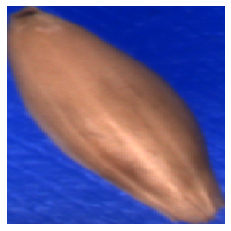

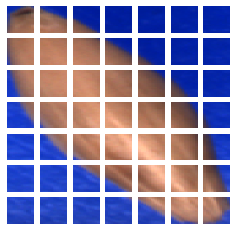

In [10]:
import matplotlib.pyplot as plt

size = (image_size,image_size)

for x_train, y_train in train_ds.take(1):
    print()
    
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.numpy().astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(tf.convert_to_tensor([image]), size=(image_size, image_size))

patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [11]:
def create_cross_attention_module(
    latent_dim, data_dim, projection_dim, ffn_units, dropout_rate
):

    inputs = {
        # Recieve the latent array as an input of shape [1, latent_dim, projection_dim].
        "latent_array": layers.Input(shape=(latent_dim, projection_dim)),
        # Recieve the data_array (encoded image) as an input of shape [batch_size, data_dim, projection_dim].
        "data_array": layers.Input(shape=(data_dim, projection_dim)),
    }

    # Apply layer norm to the inputs
    latent_array = layers.LayerNormalization(epsilon=1e-6)(inputs["latent_array"])
    data_array = layers.LayerNormalization(epsilon=1e-6)(inputs["data_array"])

    # Create query tensor: [1, latent_dim, projection_dim].
    query = layers.Dense(units=projection_dim)(latent_array)
    # Create key tensor: [batch_size, data_dim, projection_dim].
    key = layers.Dense(units=projection_dim)(data_array)
    # Create value tensor: [batch_size, data_dim, projection_dim].
    value = layers.Dense(units=projection_dim)(data_array)

    # Generate cross-attention outputs: [batch_size, latent_dim, projection_dim].
    attention_output = layers.Attention(use_scale=True, dropout=0.1)(
        [query, key, value], return_attention_scores=False
    )
    # Skip connection 1.
    attention_output = layers.Add()([attention_output, latent_array])

    # Apply layer norm.
    attention_output = layers.LayerNormalization(epsilon=1e-6)(attention_output)
    # Apply Feedforward network.
    ffn = create_ffn(hidden_units=ffn_units, dropout_rate=dropout_rate)
    outputs = ffn(attention_output)
    # Skip connection 2.
    outputs = layers.Add()([outputs, attention_output])

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [12]:
def create_transformer_module(
    latent_dim,
    projection_dim,
    num_heads,
    num_transformer_blocks,
    ffn_units,
    dropout_rate,
):

    # input_shape: [1, latent_dim, projection_dim]
    inputs = layers.Input(shape=(latent_dim, projection_dim))

    x0 = inputs
    # Create multiple layers of the Transformer block.
    for _ in range(num_transformer_blocks):
        # Apply layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(x0)
        # Create a multi-head self-attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, x0])
        # Apply layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # Apply Feedforward network.
        ffn = create_ffn(hidden_units=ffn_units, dropout_rate=dropout_rate)
        x3 = ffn(x3)
        # Skip connection 2.
        x0 = layers.Add()([x3, x2])

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=x0)
    return model

In [13]:
class Perceiver(keras.Model):
    def __init__(
        self,
        patch_size,
        data_dim,
        latent_dim,
        projection_dim,
        num_heads,
        num_transformer_blocks,
        ffn_units,
        dropout_rate,
        num_iterations,
        classifier_units,
    ):
        super(Perceiver, self).__init__()

        self.latent_dim = latent_dim
        self.data_dim = data_dim
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.num_heads = num_heads
        self.num_transformer_blocks = num_transformer_blocks
        self.ffn_units = ffn_units
        self.dropout_rate = dropout_rate
        self.num_iterations = num_iterations
        self.classifier_units = classifier_units

    def build(self, input_shape):
        # Create latent array.
        self.latent_array = self.add_weight(
            shape=(self.latent_dim, self.projection_dim),
            initializer="random_normal",
            trainable=True,
        )

        # Create patching module.
        self.patcher = Patches(self.patch_size)

        # Create patch encoder.
        self.patch_encoder = PatchEncoder(self.data_dim, self.projection_dim)

        # Create cross-attenion module.
        self.cross_attention = create_cross_attention_module(
            self.latent_dim,
            self.data_dim,
            self.projection_dim,
            self.ffn_units,
            self.dropout_rate,
        )

        # Create Transformer module.
        self.transformer = create_transformer_module(
            self.latent_dim,
            self.projection_dim,
            self.num_heads,
            self.num_transformer_blocks,
            self.ffn_units,
            self.dropout_rate,
        )

        # Create global average pooling layer.
        self.global_average_pooling = layers.GlobalAveragePooling1D()

        # Create a classification head.
        self.classification_head = create_ffn(
            hidden_units=self.classifier_units, dropout_rate=self.dropout_rate
        )

        super(Perceiver, self).build(input_shape)

    def call(self, inputs):
        # Augment data.
        augmented = data_augmentation(inputs)
        # Create patches.
        patches = self.patcher(augmented)
        # Encode patches.
        encoded_patches = self.patch_encoder(patches)
        # Prepare cross-attention inputs.
        cross_attention_inputs = {
            "latent_array": tf.expand_dims(self.latent_array, 0),
            "data_array": encoded_patches,
        }
        # Apply the cross-attention and the Transformer modules iteratively.
        for _ in range(num_iterations):
            # Apply cross-attention from the latent array to the data array.
            latent_array = self.cross_attention(cross_attention_inputs)
            # Apply self-attention Transformer to the latent array.
            latent_array = self.transformer(latent_array)
            # Set the latent array of the next iteration.
            cross_attention_inputs["latent_array"] = latent_array

        # Apply global average pooling to generate a [batch_size, projection_dim] repesentation tensor.
        representation = self.global_average_pooling(latent_array)
        # Generate logits.
        logits = self.classification_head(representation)
        return logits

In [14]:
def acc_grain(y_true, y_pred):
    y_true_class = K.argmax(y_true, axis=-1)
    y_pred_class = K.argmax(y_pred, axis=-1)
    sample_weight = np.hstack((np.where(y_true_class.numpy().reshape(-1,1)==7,True,False),np.where(y_true_class.numpy().reshape(-1,1)==24,True,False),np.where(y_true_class.numpy().reshape(-1,1)==13,True,False)))
    sample_weight = np.any(sample_weight,axis=1)
    sample_weight = np.where(sample_weight,8.94,1.0)
    return K.constant(accuracy_score(y_true_class,y_pred_class,sample_weight=sample_weight))

def get_cosine_schedule_with_warmup(lr, num_warmup_steps, num_training_steps, num_cycles=0.5):
    """
    Modified the get_cosine_schedule_with_warmup from huggingface for tensorflow
    (https://huggingface.co/transformers/_modules/transformers/optimization.html#get_cosine_schedule_with_warmup)

    Create a schedule with a learning rate that decreases following the
    values of the cosine function between 0 and `pi * cycles` after a warmup
    period during which it increases linearly between 0 and 1.
    """

    def lrfn(epoch):
        if epoch < num_warmup_steps:
            return float(epoch) / float(max(1, num_warmup_steps)) * lr
        progress = float(epoch - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr

    return tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

In [15]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [17]:
def run_experiment(model):

    # Create LAMB optimizer with weight decay.
    optimizer = tfa.optimizers.LAMB(learning_rate=learning_rate, weight_decay_rate=weight_decay,)

    # Compile the model.
    model.compile(optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=[acc_grain],run_eagerly=True
    )

    # Create a learning rate scheduler callback.
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3)

    # Create an early stopping callback.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
    filename = 'checkpoints'
    checkpoint = ModelCheckpoint(filename, monitor='val_acc_grain', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
    weights = dict(zip([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27], [1,1,1,1,1,1,1,8.94,1,1,1,1,1,8.94,1,1,1,1,1,1,1,1,1,1,8.94,1,1,1]))

    # Fit the model.
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        batch_size=batch_size,
        epochs=num_epochs,
        callbacks=[checkpoint, early_stopping, reduce_lr],class_weight=weights,verbose=1
    )

    _, accuracy, top_5_accuracy = model.evaluate(val_ds)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    # Return history to plot learning curves.
    return history

perceiver_classifier = Perceiver(
    patch_size,
    num_patches,
    latent_dim,
    projection_dim,
    num_heads,
    num_transformer_blocks,
    ffn_units,
    dropout_rate,
    num_iterations,
    classifier_units,
)

history = run_experiment(perceiver_classifier)

Epoch 1/25


TypeError: call() got an unexpected keyword argument 'return_attention_scores'

In [ ]:
tf.__version__

In [ ]:
import matplotlib.pyplot as plt
# Plot training & validation iou_score values
plt.figure(figsize=(30, 20))
plt.subplot(121)
plt.plot(history.history['acc_grain'])
plt.plot(history.history['val_acc_grain'])
plt.title('Model acc_score')
plt.ylabel('acc_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
from tensorflow.keras.preprocessing import image
import pandas as pd
import zipfile
import csv

start = time.time()

def load_class_list(class_list_file):
    class_list = []
    with open(class_list_file, 'r') as csvfile:
        file_reader = csv.reader(csvfile)
        for row in file_reader:
            class_list.append(row[0])
    class_list.sort()
    return class_list

class_list = load_class_list('class_list.txt')

IMG_SIZE=224
LBL = dict(zip(class_list, range(28)))

cls_map = dict(zip(LBL.values(),LBL.keys()))

def init_dir(pth):
    if os.path.exists(pth):
        shutil.rmtree(pth)
    os.mkdir(pth)

logger.info("loading the model")
model = model_fn(args['model_dir'])
logger.info("Reading the test set")

res = []
for fn in glob.iglob(args['data_dir'] + 'val/**/*.png', recursive=True):
    file_name = os.path.basename(fn)
    path = os.path.abspath(fn)
    folder = os.path.split(os.path.dirname(path))[1]
    if len(file_name.split("-")) > 2:  # ignore master image with may grains, raw image names are in guid format
        im = image.load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
        img_array = image.img_to_array(im)
        img_batch = np.expand_dims(img_array, axis=0)
        img_preprocessed = preprocess_input(img_batch)
        pred = model.predict(img_preprocessed)
        top3 = (-pred[0]).argsort()[:3]
        res.append({'file_name': file_name, 'path': path, 'cls': folder, 'prediction':top3[0],  'proba_1':pred[0][top3[0]], 'prediction2':top3[1], 'proba_2':pred[0][top3[1]],  'prediction3':top3[2], 'proba_3':pred[0][top3[2]]})

df = pd.DataFrame(res)
df['prediction'] = df.prediction.map(cls_map)
df['prediction2'] = df.prediction2.map(cls_map)
df['prediction3'] = df.prediction3.map(cls_map)

from sklearn.metrics import accuracy_score

def w(x):
    if "_SOUND" in x:
        return 8.94 # weighting  Healthy grains more important than defective grains
    return 1

def scoring_fn(df):
    """
    Weighted Accuracy Metric 90% Healthy grains, 10% unhealthy grains
    """
    df['weight'] = df.cls.apply(w)
    return accuracy_score(df.cls,df.prediction,sample_weight=df.weight)

logger.info(f"predictions have shape of {df.shape}")

score = scoring_fn(df)
print ("Accuracy Score:" + str(score))
# write to the output location

print('Duration Run',(time.time()-start)/3600,' hours')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(df['cls'], df['prediction']))

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
ticks=np.linspace(0, 27,num=28)
plt.figure(figsize=(15,15))
plt.imshow(confusion_matrix(df['cls'], df['prediction'],normalize='true'), interpolation='none')
plt.colorbar()
plt.xticks(ticks,fontsize=6)
plt.yticks(ticks,fontsize=6)
plt.grid(True)
plt.show()

In [ ]:
from keras_preprocessing import image

In [ ]:
NUM_CLASSES=28
model = build_model(num_classes=NUM_CLASSES)
model.fit?

In [ ]:
image.random_rotation(90)

In [ ]:
 rotation_range=args.rotation,
      shear_range=args.shear,
      zoom_range=args.zoom,
      horizontal_flip=args.h_flip,
      vertical_flip=args.v_flip